In [3]:
import pandas as pd
import numpy as np
import os
import cv2
import matplotlib.pyplot as plt
import keras
import seaborn as sns
import pathlib
from pathlib import Path
import glob
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils  import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:

data_dir="/content/drive/MyDrive/data"
root_dir='/content/drive/MyDrive/data'

In [ ]:
def countfiles(root_dir):
    for path in pathlib.Path(root_dir).iterdir():
        if path.is_dir():
             print( str(len([name for name in os.listdir(path) \
            if os.path.isfile(os.path.join(path, name))])) + " files inside the " + \
            str(path.name),'class')
countfiles(data_dir)

1336 files inside the Common_Rust class
594 files inside the Gray_Leaf_Spot class
1166 files inside the Blight class
1172 files inside the Healthy class


In [ ]:
def data_categories(d_path):
    categories=[]    #listdir-->used to get the list of all files and directories in the specified directory
    for folder_name in os.listdir(d_path):  #os.path.isdir()--->used to check whether the specified path is an existing directory or not.
        if os.path.isdir(os.path.join(d_path,folder_name)):
            no_of_files = len(glob.glob(os.path.join(d_path, folder_name)+"/*.JPG")) + len(glob.glob(os.path.join(d_path, folder_name)+"/*.jpg"))
            categories.append(np.array([folder_name,no_of_files]))
    categories.sort(key=lambda a:a[0])
    cat=np.array(categories)
    return list(cat[:, 0]),list(cat[:,1])
categories,no_of_files = data_categories("/content/drive/MyDrive/data")
print(categories)

['Blight', 'Common_Rust', 'Gray_Leaf_Spot', 'Healthy']


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
print("number of categories: ", len(categories))

number of categories:  4


In [ ]:
df = pd.DataFrame({"category": categories, "number of files": no_of_files})
df

,category,number of files
0,Blight,1165
1,Common_Rust,1336
2,Gray_Leaf_Spot,594
3,Healthy,1172


In [ ]:
def dataset(data_path, categories, width, height):
    x = []
    y = []
    for category_idx, category in enumerate(categories):
        path = os.path.join(data_path, category)
        count = 0
        for img in os.listdir(path):
            img_array = cv2.imread(os.path.join(path,img))
            img_size = cv2.resize(img_array, (width, height))
            x.append(img_size)
            y.append(category_idx)
            count += 1
        print(f"Number of images in class {category_idx}: {count}")
    y = np.array(y)
    x = np.array(x).reshape(y.shape[0], width, height, 3)
    return x, y

In [ ]:
x, y = dataset(data_path=data_dir, categories=['Blight', 'Common_Rust', 'Gray_Leaf_Spot', 'Healthy'], width=100,height=100)


Number of images in class 0: 1166
Number of images in class 1: 1336
Number of images in class 2: 594
Number of images in class 3: 1172


In [ ]:
print(f'x shape:{x.shape}')
print(f"y shape: {y.shape}")

x shape:(4268, 100, 100, 3)
y shape: (4268,)


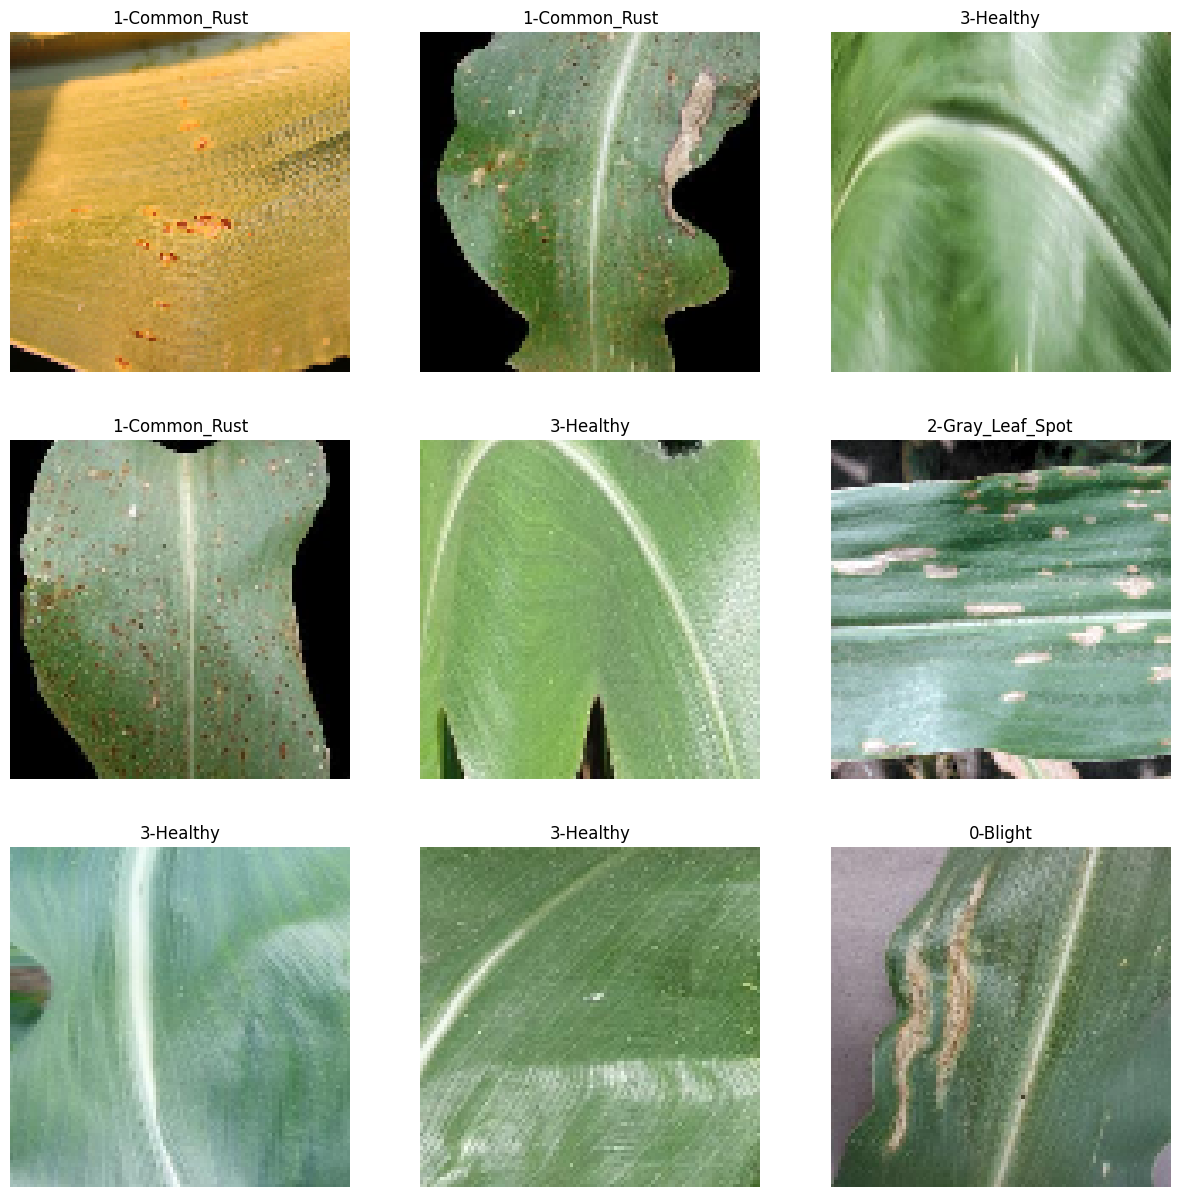

In [ ]:
plt.figure(figsize=(15, 15))
num_images = len(x)
for i in range(9):
    plt.subplot(3, 3, i + 1)
    idx = np.random.randint(0, num_images)
    plt.rcParams.update({'font.size':10})
    plt.imshow(x[idx][:, :, ::-1])
    plt.title(f"{y[idx]}-{categories[y[idx]]}")
    plt.axis("off")
plt.show()

In [ ]:
y=np.reshape(y,(len(y),1))
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.1,random_state=42)
print(f"x_train: {x_train.shape}")
print(f"y_train: {y_train.shape}")
print(f"x_test: {x_test.shape}")
print(f"y_test: {y_test.shape}")

x_train: (3841, 100, 100, 3)
y_train: (3841, 1)
x_test: (427, 100, 100, 3)
y_test: (427, 1)


In [ ]:
x_train,x_val,y_train,y_val=train_test_split(x_train,y_train,train_size=0.70)
x_test=x_test

print(f"x_train:{x_train.shape},y_train:{y_train.shape}")
print(f"x_val: {x_val.shape},y_val:{y_val.shape}")        #70-20-10
print(f"x_test:{x_test.shape},y_test:{y_test.shape}")

x_train:(2688, 100, 100, 3),y_train:(2688, 1)
x_val: (1153, 100, 100, 3),y_val:(1153, 1)
x_test:(427, 100, 100, 3),y_test:(427, 1)


In [ ]:
y_train = to_categorical(y_train)
y_val = to_categorical(y_val)
y_test = to_categorical(y_test)

print(f"x_train:{x_train.shape},  y_train:{y_train.shape}")
print(f"x_val:{x_val.shape},  y_val:{y_val.shape}")
print(f"x_test:{x_test.shape},  y_test:{y_test.shape}")

x_train:(2688, 100, 100, 3),  y_train:(2688, 4)
x_val:(1153, 100, 100, 3),  y_val:(1153, 4)
x_test:(427, 100, 100, 3),  y_test:(427, 4)


In [ ]:
train_generator=ImageDataGenerator(rescale=1./255,
                                   rotation_range=2,
                                  horizontal_flip=True,
                                   shear_range=0.5,
                                  zoom_range=0.7)
val_generator=ImageDataGenerator(rescale=1./255,
                                 rotation_range=2,
                                 horizontal_flip=True,
                                 shear_range=0.5,
                                 zoom_range=0.1)
test_generator=ImageDataGenerator(rotation_range=2,
                                 horizontal_flip=True,
                                 zoom_range=0.1)

train_generator.fit(x_train)
val_generator.fit(x_val)
test_generator.fit(x_test)

In [ ]:
from keras.models import Sequential, load_model
from keras.layers import Flatten, Dense,MaxPooling2D,Dropout,Conv2D

In [ ]:
model = keras.Sequential([
    # Convolutional layers
                   #kernels,  #filters ,  #activation function,          #input
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(100,100,3)),
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2,2)),
    tf.keras.layers.Dropout(0.25),

    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2,2)),
    tf.keras.layers.Dropout(0.25),

    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2,2)),
    tf.keras.layers.Dropout(0.25),


    tf.keras.layers.Conv2D(256, (3,3), activation='relu'),
    tf.keras.layers.Conv2D(256, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2,2)),
    tf.keras.layers.Dropout(0.25),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(0.5),#0.2#0.5
    tf.keras.layers.Dense(4, activation='softmax')])


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 98, 98, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 96, 96, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 48, 48, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 48, 48, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 46, 46, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 44, 44, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 22, 22, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 22, 22, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 20, 20, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 18, 18, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 9, 9, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 9, 9, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 7, 7, 256)           │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 5, 5, 256)           │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 2, 2, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 2, 2, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │         524,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 4)                   │           2,052 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,699,108 (6.48 MB)

 Trainable params: 1,699,108 (6.48 MB)

 Non-trainable params: 0 (0.00 B)

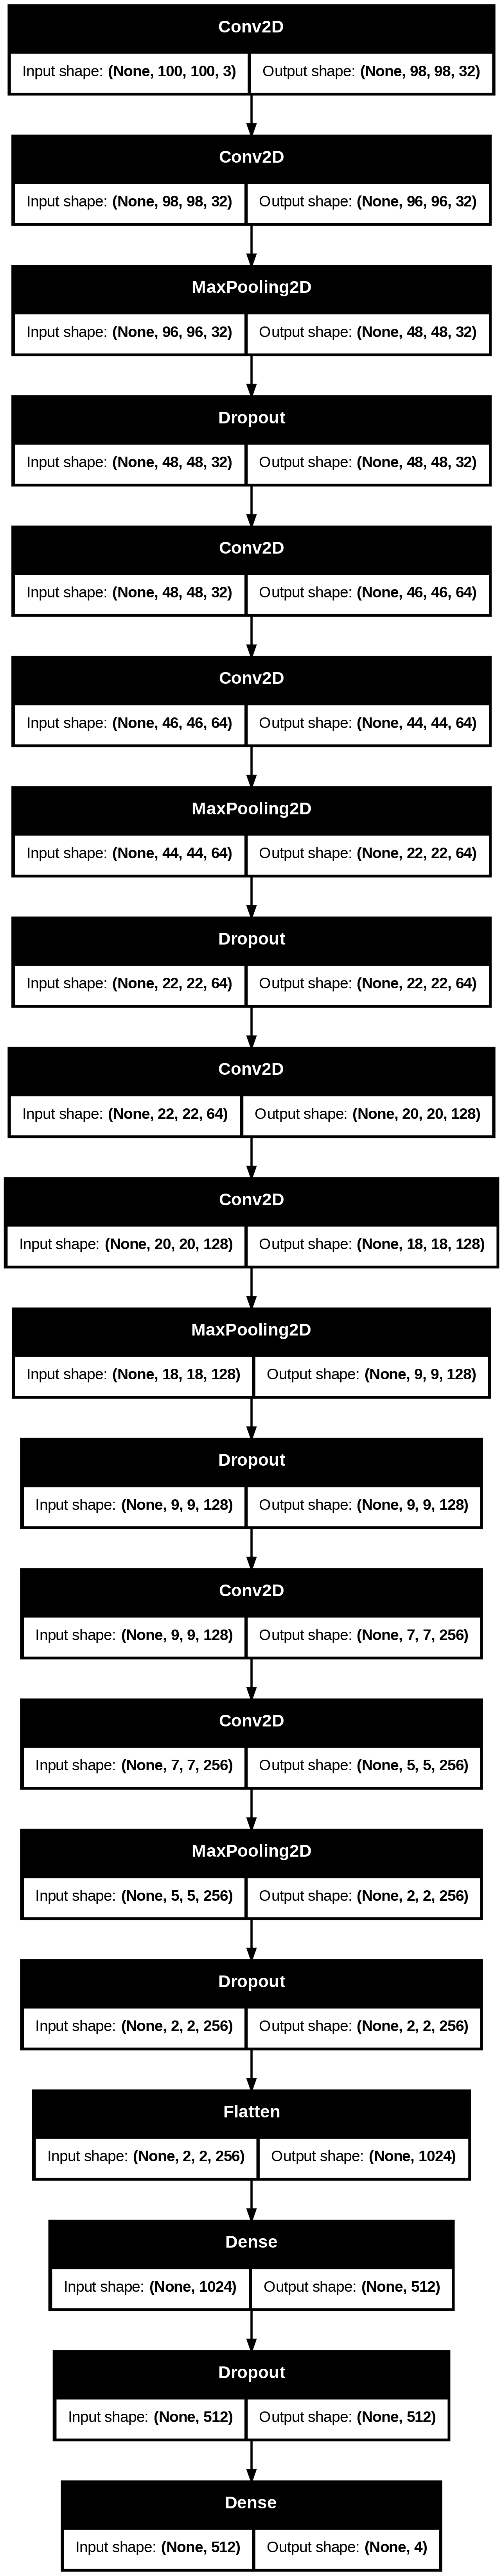

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(model,show_shapes=True,to_file='/content/drive/MyDrive/data/model.png')

In [ ]:
from keras.metrics import Precision,Recall

In [ ]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy',Precision(name='precision'),Recall(name='Recall')])

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint

model_filepath='/content/drive/MyDrive/data/model.keras'
checkpt=ModelCheckpoint(filepath=model_filepath,
                        monitor='accuracy',
                        mode='max',
                        save_best_only=True)

In [ ]:
history = model.fit(x_train,y_train, epochs=40,batch_size=120,
                    validation_data = val_generator.flow(x_val,y_val,batch_size=120),
                   validation_steps=200,
                   verbose=1,callbacks=[checkpt])
history=history.history
model.save('/content/drive/MyDrive/data/model.h5')

Epoch 1/40
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 457ms/step - Recall: 0.1366 - accuracy: 0.2882 - loss: 6.3306 - precision: 0.2791

/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


23/23 ━━━━━━━━━━━━━━━━━━━━ 39s 981ms/step - Recall: 0.1333 - accuracy: 0.2887 - loss: 6.1938 - precision: 0.2792 - val_Recall: 0.0000e+00 - val_accuracy: 0.3131 - val_loss: 1.3828 - val_precision: 0.0000e+00
Epoch 2/40
23/23 ━━━━━━━━━━━━━━━━━━━━ 13s 323ms/step - Recall: 0.0335 - accuracy: 0.3474 - loss: 1.3112 - precision: 0.7224 - val_Recall: 0.0000e+00 - val_accuracy: 0.3131 - val_loss: 1.3819 - val_precision: 0.0000e+00
Epoch 3/40
23/23 ━━━━━━━━━━━━━━━━━━━━ 5s 201ms/step - Recall: 0.1685 - accuracy: 0.4654 - loss: 1.1897 - precision: 0.6805 - val_Recall: 0.0000e+00 - val_accuracy: 0.2680 - val_loss: 1.3976 - val_precision: 0.0000e+00
Epoch 4/40
23/23 ━━━━━━━━━━━━━━━━━━━━ 7s 320ms/step - Recall: 0.3475 - accuracy: 0.5935 - loss: 0.9228 - precision: 0.7828 - val_Recall: 0.0000e+00 - val_accuracy: 0.2680 - val_loss: 1.3974 - val_precision: 0.0000e+00
Epoch 5/40
23/23 ━━━━━━━━━━━━━━━━━━━━ 8s 203ms/step - Recall: 0.7047 - accuracy: 0.7684 - loss: 0.6153 - precision: 0.8294 - val_Recall: 

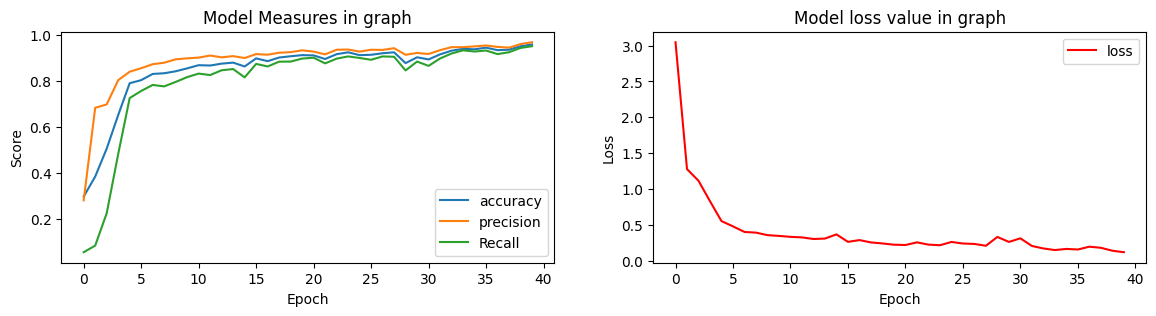

In [ ]:
fig = plt.figure(figsize=(14, 3))
ax1 = fig.add_subplot(1, 2, 1)
ax1.plot(history['accuracy'])
ax1.plot(history['precision'])
ax1.plot(history["Recall"])
ax1.legend(['accuracy','precision','Recall'])
ax1.set_title('Model Measures in graph')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Score')

ax2 = fig.add_subplot(1, 2, 2)
ax2.plot(history['loss'],color='red')
ax2.legend(['loss'])
ax2.set_title('Model loss value in graph')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')

plt.savefig('/content/drive/MyDrive/data/graph.png')
plt.show()

In [ ]:
best=load_model("/content/drive/MyDrive/data/model.keras")
testscore=best.evaluate(x_test,y_test)
testscore

14/14 ━━━━━━━━━━━━━━━━━━━━ 4s 116ms/step - Recall: 0.9143 - accuracy: 0.9206 - loss: 0.2635 - precision: 0.9253


[0.2776944935321808,
 0.9297423958778381,
 0.9336493015289307,
 0.9227166175842285]

In [ ]:
print('TEST DATA')
print('')
print(f"Accuracy: {round(testscore[1]*100,2)}%")
print(f"Precision: {round(testscore[2]*100,2)}%")
print(f"Recall: {round(testscore[3]*100,2)}%")
print(f"Loss: {testscore[0]}")

TEST DATA

Accuracy: 92.97%
Precision: 93.36%
Recall: 92.27%
Loss: 0.2776944935321808


In [ ]:
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

In [ ]:
class_names= ['Blight', 'Common_Rust', 'Gray_Leaf_Spot', 'Healthy']

In [ ]:
y_pred=np.argmax(best.predict(x_test),axis=1)
y_true=np.argmax(y_test,axis=1)

14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step


In [ ]:
c_test=confusion_matrix(y_true,y_pred)
c_test

array([[116,   0,   9,   0],
       [  8, 127,   5,   0],
       [  6,   0,  48,   0],
       [  0,   1,   1, 106]])

In [ ]:
print(classification_report(y_true,y_pred,target_names=class_names))

                precision    recall  f1-score   support

        Blight       0.89      0.93      0.91       125
   Common_Rust       0.99      0.91      0.95       140
Gray_Leaf_Spot       0.76      0.89      0.82        54
       Healthy       1.00      0.98      0.99       108

      accuracy                           0.93       427
     macro avg       0.91      0.93      0.92       427
  weighted avg       0.94      0.93      0.93       427



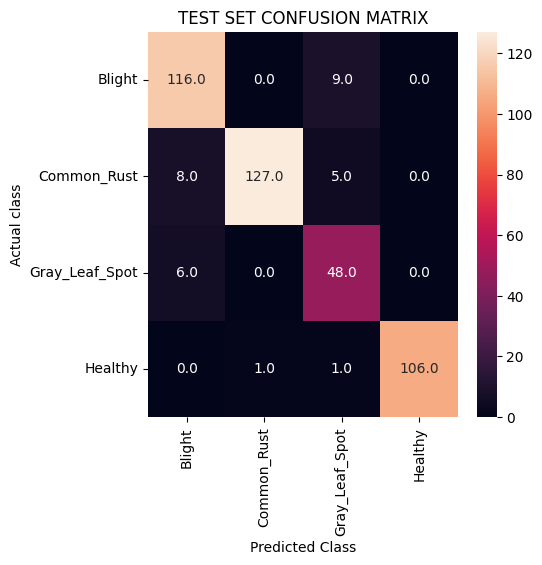

In [ ]:
plt.figure(figsize=(5,5))
sns.heatmap(c_test,annot=True,xticklabels=class_names,yticklabels=class_names,fmt='.1f')
plt.title('TEST SET CONFUSION MATRIX')
plt.xlabel("Predicted Class")
plt.ylabel("Actual class")
plt.savefig('/content/drive/MyDrive/data/cm_test.png')
plt.show()

In [ ]:
print(f"TEST SET")
print('')
for i in range(4):
    tp = c_test[i, i]
    tn = np.sum(c_test) - np.sum(c_test[i, :]) - np.sum(c_test[:, i]) + c_test[i, i]
    fp = np.sum(c_test[:, i]) - c_test[i, i]
    fn = np.sum(c_test[i, :]) - c_test[i, i]
    print(f"Class {i}: TP={tp}, TN={tn}, FP={fp}, FN={fn}")

TEST SET

Class 0: TP=116, TN=288, FP=14, FN=9
Class 1: TP=127, TN=286, FP=1, FN=13
Class 2: TP=48, TN=358, FP=15, FN=6
Class 3: TP=106, TN=319, FP=0, FN=2


In [ ]:
valscore=best.evaluate(x_val,y_val)
valscore

37/37 ━━━━━━━━━━━━━━━━━━━━ 2s 56ms/step - Recall: 0.8892 - accuracy: 0.8968 - loss: 0.3905 - precision: 0.9063


[0.34256711602211, 0.9037293791770935, 0.9105263352394104, 0.9002602100372314]

In [ ]:
print('VALIDATION DATA')
print('')
print(f"Accuracy: {round(valscore[1]*100,2)}%")
print(f"Precision: {round(valscore[2]*100,2)}%")
print(f"Recall: {round(valscore[3]*100,2)}%")
print(f"Loss: {valscore[0]}")

VALIDATION DATA

Accuracy: 90.37%
Precision: 91.05%
Recall: 90.03%
Loss: 0.34256711602211


In [ ]:
yv_pred=np.argmax(best.predict(x_val),axis=1)
yv_true=np.argmax(y_val,axis=1)

37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step


In [ ]:
c_val=confusion_matrix(yv_true,yv_pred)
c_val

array([[260,   3,  46,   0],
       [ 11, 331,  18,   1],
       [ 29,   1, 131,   0],
       [  1,   0,   1, 320]])

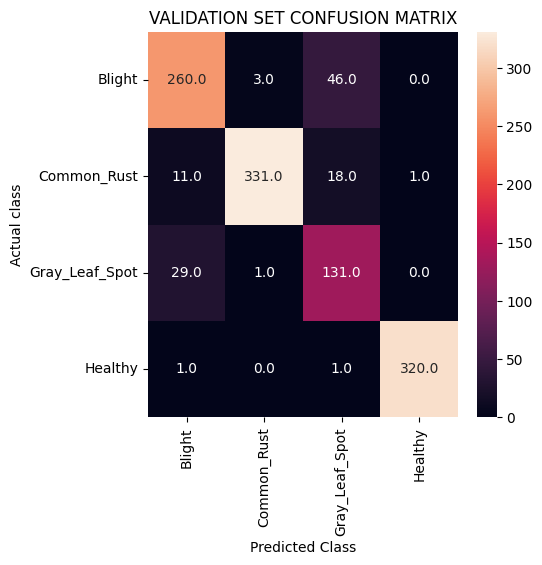

In [ ]:
plt.figure(figsize=(5,5))
sns.heatmap(c_val,annot=True,xticklabels=class_names,yticklabels=class_names,fmt='.1f')
plt.title('VALIDATION SET CONFUSION MATRIX')
plt.xlabel("Predicted Class")
plt.ylabel("Actual class")
plt.savefig('/content/drive/MyDrive/data/cm_VAL.png')
plt.show()

In [ ]:
print(classification_report(yv_true,yv_pred,target_names=class_names))

                precision    recall  f1-score   support

        Blight       0.86      0.84      0.85       309
   Common_Rust       0.99      0.92      0.95       361
Gray_Leaf_Spot       0.67      0.81      0.73       161
       Healthy       1.00      0.99      1.00       322

      accuracy                           0.90      1153
     macro avg       0.88      0.89      0.88      1153
  weighted avg       0.91      0.90      0.91      1153



In [ ]:
print(f"VALIDATION SET")
print('')
for i in range(4):
    tp = c_val[i, i]
    tn = np.sum(c_val) - np.sum(c_val[i, :]) - np.sum(c_val[:, i]) + c_val[i, i]
    fp = np.sum(c_val[:, i]) - c_val[i, i]
    fn = np.sum(c_val[i, :]) - c_val[i, i]
    print(f"Class {i}: TP={tp}, TN={tn}, FP={fp}, FN={fn}")

VALIDATION SET

Class 0: TP=260, TN=803, FP=41, FN=49
Class 1: TP=331, TN=788, FP=4, FN=30
Class 2: TP=131, TN=927, FP=65, FN=30
Class 3: TP=320, TN=830, FP=1, FN=2


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 282ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


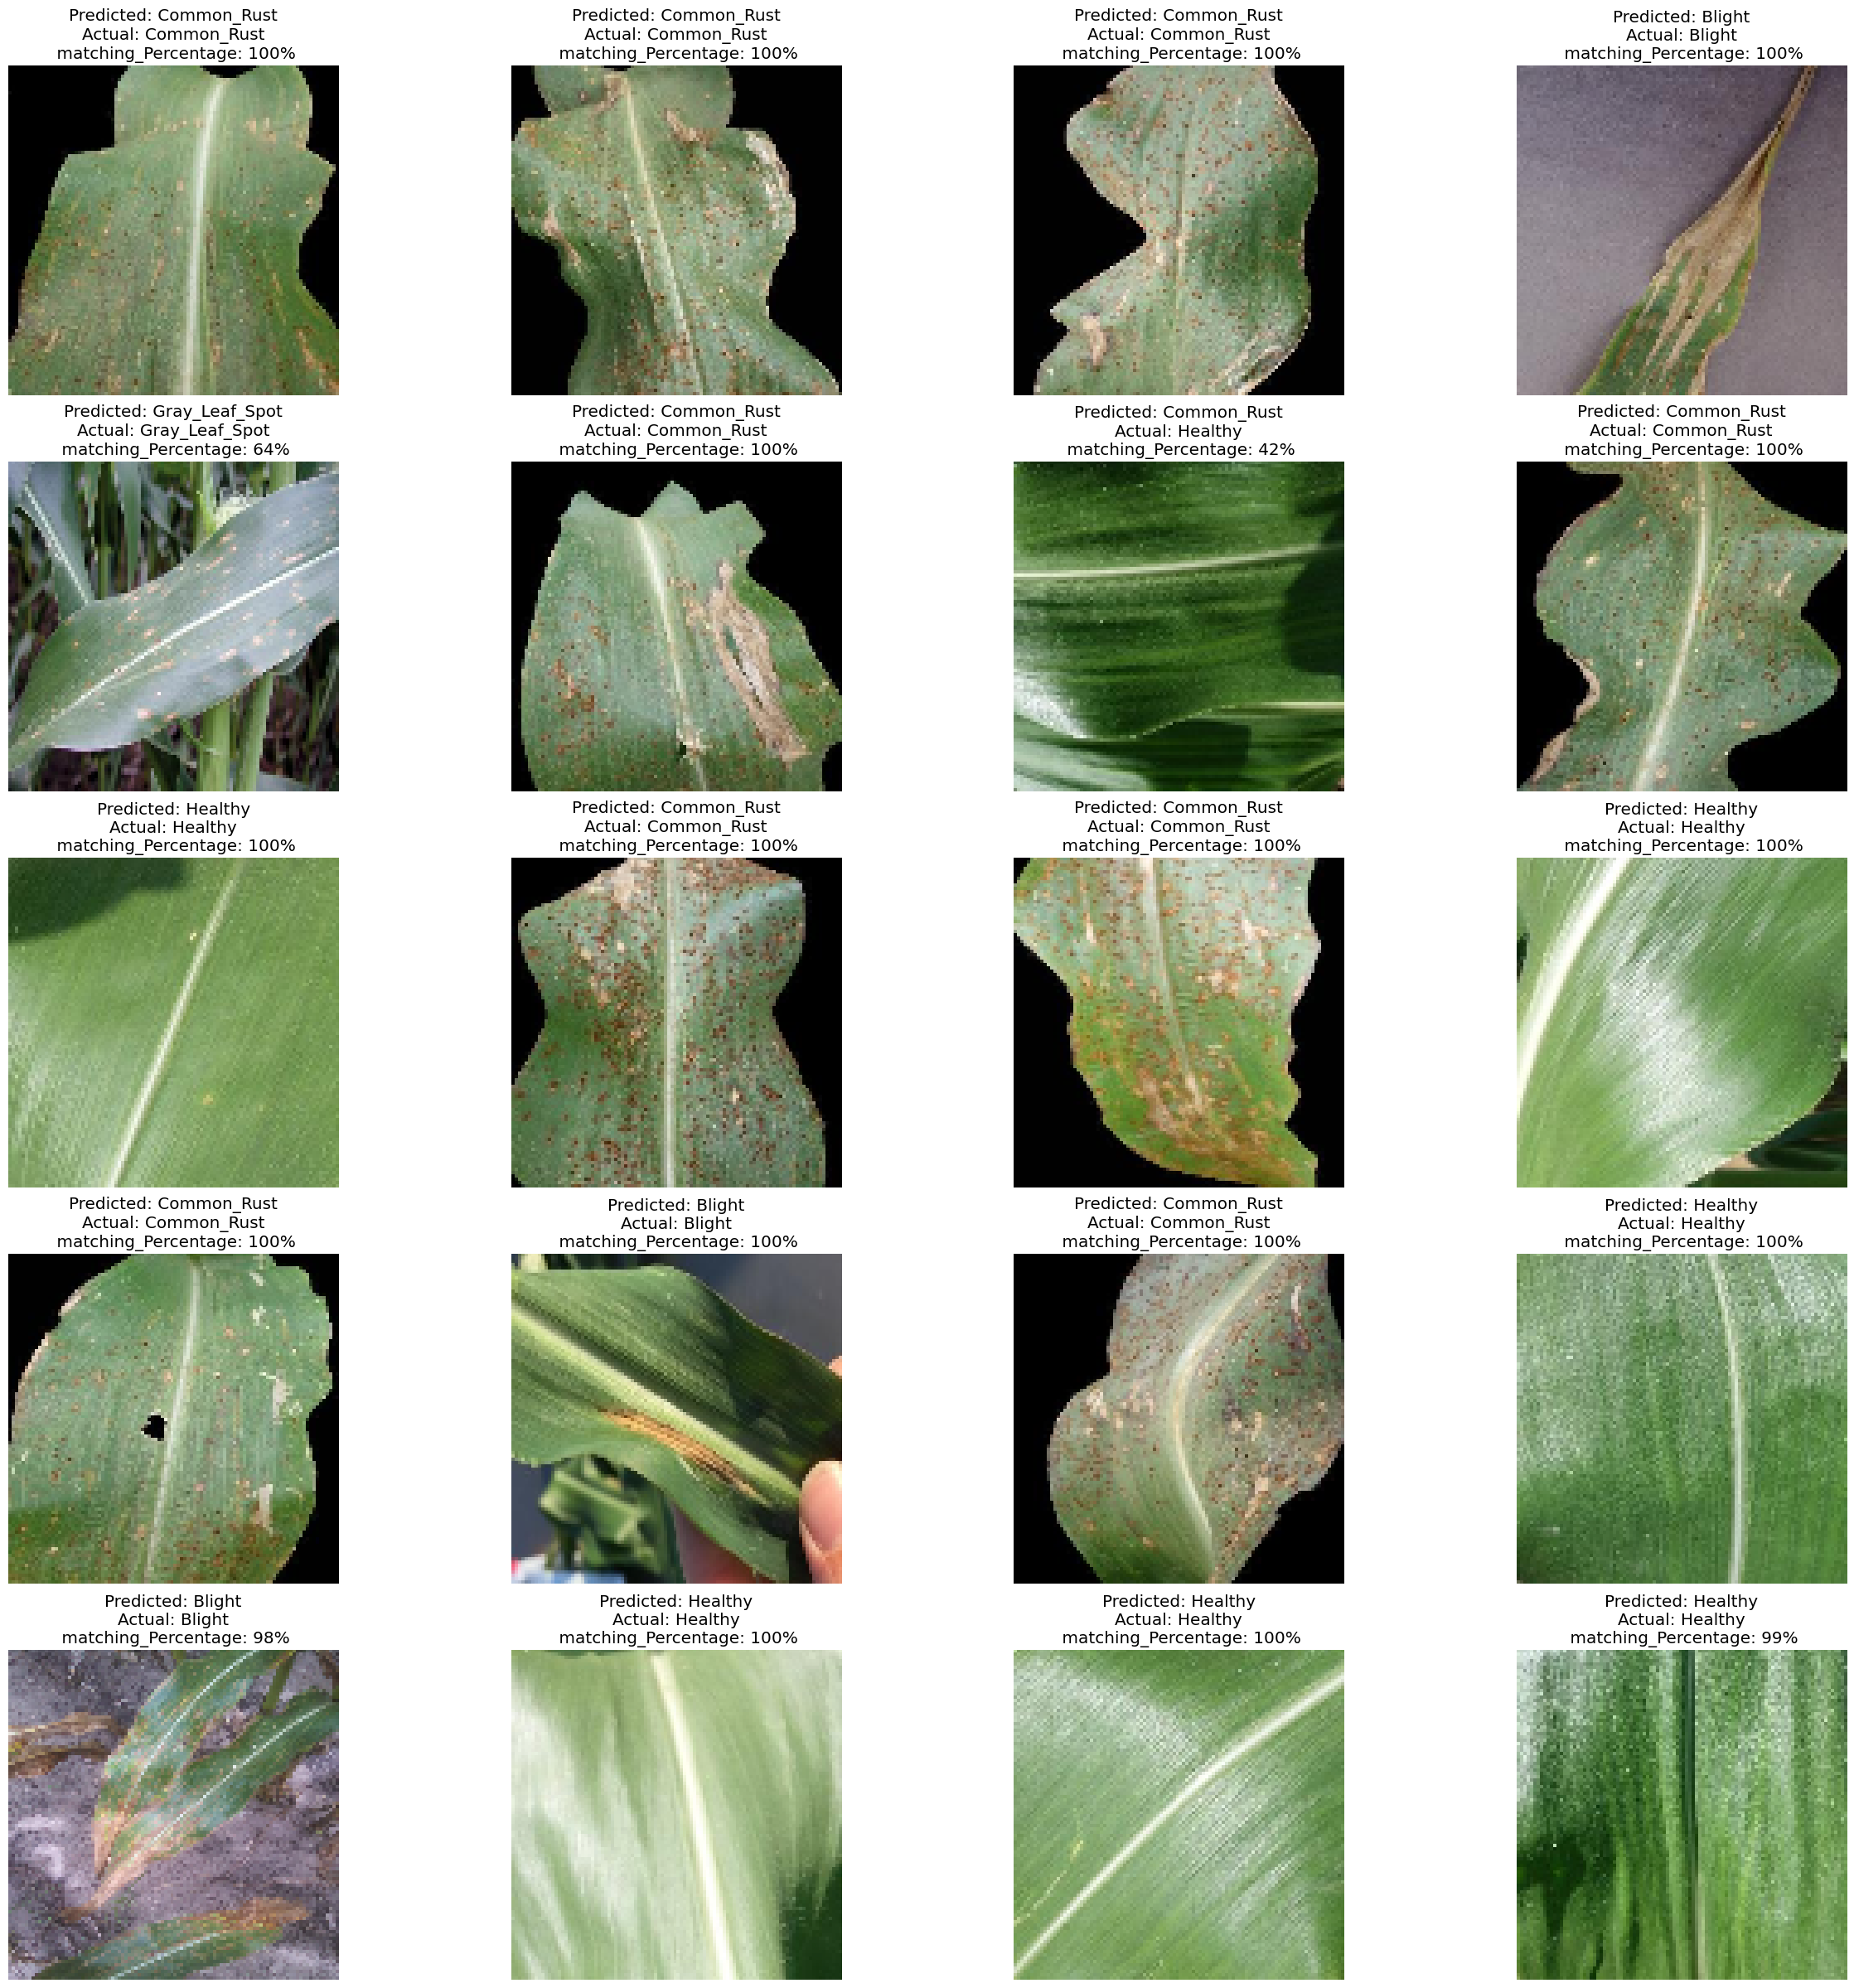

In [ ]:

plt.figure(figsize=(30, 30))
plt.subplots_adjust(wspace=0.2, hspace=0.2)
for i in range(20):
    idx = np.random.randint(len(y))
    img, true_class = x[idx], categories[y[idx].squeeze()]

    # predict class probabilities for the current image
    probs = model.predict(img[None, :, :, :])[0]
    pred_class = categories[np.argmax(probs)]
    max_prob = np.max(probs)*100
    plt.rcParams.update({'font.size':12})
    plt.subplot(5, 4, i + 1)
    plt.imshow(img[:, :, ::-1])
    plt.title(f"Predicted: {pred_class}\nActual: {true_class}\n matching_Percentage: {round(max_prob)}%")
    plt.axis("off")
plt.show()

In [5]:
image = cv2.imread('/content/drive/MyDrive/data/Blight/Corn_Blight (1001).JPG')
resized_image = cv2.resize(image, (32, 32))

filename = "/content/drive/MyDrive/data/blight_resized.jpg"
cv2.imwrite(filename, resized_image)

True